In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM, Dropout, Dense, InputLayer
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
import glob
import os

In [2]:
# npz data to pd.
def npz_to_csv(file_path):
    file = np.load(file_path, allow_pickle=True)
    X_df = pd.DataFrame(file['X'])
    y_df = pd.DataFrame(file['y'])
    return X_df, y_df

Time series 데이터에대하여 Pandas dataframe을 입력으로 받으면 lstm모델로 학습 후, 검증 loss값들과 accuracy값들을 return해주는 함수

In [51]:
def create_sequences(data, timestep):
    sequences = []
    for i in range(len(data) - timestep + 1):
        sequences.append(data[i:i + timestep])
    return np.array(sequences)


In [54]:
def train_and_evaluate_lstm(X, y, n_splits=5, epochs=30, batch_size=32, timestep=5):
    # 데이터 정규화
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # 데이터를 시퀀스로 변환
    X_sequences = create_sequences(X_scaled, timestep)
    y_sequences = y.iloc[timestep - 1:].values  # 시퀀스에 맞게 y도 변환

    tscv = TimeSeriesSplit(n_splits=n_splits)
    val_losses = []
    val_accs = []

    fold = 1
    for train_idx, test_idx in tscv.split(X_sequences):
        X_train, X_test = X_sequences[train_idx], X_sequences[test_idx]
        y_train, y_test = y_sequences[train_idx], y_sequences[test_idx]

        display(X_train.shape)
        model = Sequential()
        model.add(LSTM(input_shape=(timestep, X_train.shape[2]), units=50, return_sequences=True))
        model.add(Dropout(0.2))
        model.add(LSTM(units=50, return_sequences=False))
        model.add(Dropout(0.2))
        model.add(Dense(units=1, activation='sigmoid'))

        model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)

        # 가장 좋은 검증 성능을 기록
        best_val_loss = min(history.history['val_loss'])
        best_val_acc = max(history.history['val_accuracy'])
        val_losses.append(best_val_loss)
        val_accs.append(best_val_acc)

        print(f"Fold {fold}, Best Validation Loss: {best_val_loss}, Best Validation Accuracy: {best_val_acc}")

        fold += 1

    mean_val_loss = np.mean(val_losses)
    mean_val_acc = np.mean(val_accs)

    print(f"Mean Best Validation Loss: {mean_val_loss}")
    print(f"Mean Best Validation Accuracy: {mean_val_acc}")

    return val_losses, val_accs


val losses와 val acc를 한 번에 plotting하는 함수

In [48]:
def plot_validation_metrics(val_losses, val_accs):
    num_folds = len(val_losses)
    
    folds = range(1, num_folds + 1)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
    
    ax1.plot(folds, val_losses, marker='o', linestyle='-', color='b')
    ax1.set_ylabel('Validation Loss')
    ax1.set_title('Validation Loss and Accuracy')
    ax1.grid(True)
    
    ax2.plot(folds, val_accs, marker='o', linestyle='-', color='g')
    ax2.set_xlabel('Fold')
    ax2.set_ylabel('Validation Accuracy')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

Anomaly data 비율을 나타내는 함수.
혹시 너무 accuracy가 정확하게 나오는 경우, 모든 데이터셋에 대하여 0이라고 판단했는데 알고보니 레이블이 0인 데이터의 개수가 엄청나게 많을 수 있음.
따라서 항상 의심할 것

In [7]:
def get_anomaly_rate(y):
    return y.value_counts()[1] / (y.value_counts()[0] + y.value_counts()[1])

모든 val_losses와 val_accs를 데이터셋 인덱스에 따라 dictionary로 저장하기 위한 변수

In [8]:
val_dict = {}
def append_to_val_dict(index, val_loss, val_acc):
    val_dict[index] = (val_loss, val_acc)

학습 완료된 경우 스프레드시트에 적어주세요!
한 데이터셋에 너무 시간을 많이 쓰실 필요는 없습니다. 학습할 내용도 많고 다른 모델도 많이 테스트해봐야 해요.
그리고 학습은 각 데이터셋에 대해 시간이 어느정도 소요되기 때문에 학습 과정에서는 다른 공부 하시는걸 추천드립니다.

In [9]:
# file_path = '/path/to/Classical' 각자가 저장한 폴더로 연결해주세요
file_path = './datasets/Classical/*.npz'
file_list = glob.glob(file_path)

In [10]:
file_list

['./datasets/Classical\\10_smd.npz',
 './datasets/Classical\\11_psm.npz',
 './datasets/Classical\\12_smap.npz',
 './datasets/Classical\\13_msl.npz',
 './datasets/Classical\\14_PlantMonitoring.npz',
 './datasets/Classical\\15_Multistage.npz',
 './datasets/Classical\\16_Helicopter.npz',
 './datasets/Classical\\17_kdd.npz',
 './datasets/Classical\\18_Robotfail.npz',
 './datasets/Classical\\19_Anneal.npz',
 './datasets/Classical\\1_wafer.npz',
 './datasets/Classical\\20_Glass2.npz',
 './datasets/Classical\\21_Engine.npz',
 './datasets/Classical\\22_Castmetal.npz',
 './datasets/Classical\\23_Steelfault.npz',
 './datasets/Classical\\24_Cylinderbands.npz',
 './datasets/Classical\\25_Gasdrift.npz',
 './datasets/Classical\\26_Electricity.npz',
 './datasets/Classical\\27_DElevators.npz',
 './datasets/Classical\\28_Robotnav.npz',
 './datasets/Classical\\29_Megawatt.npz',
 './datasets/Classical\\2_pdm_anreal.npz',
 './datasets/Classical\\30_Demomatlab.npz',
 './datasets/Classical\\31_Milling.npz',

폴더안에 자동으로 학습하고 기록하고싶은 데이터만 넣어두고, 이 밑에 코드 돌려두세요.

In [55]:
anomaly_rates = {}
file_idx = 1
for file in file_list:
    X, y = npz_to_csv(file)
    
    anomaly_rates[file_idx] = get_anomaly_rate(y)
    val_losses, val_accs = train_and_evaluate_lstm(X, y)
    append_to_val_dict(file_idx, val_losses, val_accs)
    file_idx += 1
    

(118071, 5, 38)

Epoch 1/30
3690/3690 [==============================] - 21s 5ms/step - loss: 0.0633 - accuracy: 0.9850 - val_loss: 0.4734 - val_accuracy: 0.7969
Epoch 2/30
3690/3690 [==============================] - 19s 5ms/step - loss: 0.0508 - accuracy: 0.9862 - val_loss: 0.8156 - val_accuracy: 0.7209
Epoch 3/30
3690/3690 [==============================] - 19s 5ms/step - loss: 0.0448 - accuracy: 0.9871 - val_loss: 0.8241 - val_accuracy: 0.7702
Epoch 4/30
3690/3690 [==============================] - 18s 5ms/step - loss: 0.0385 - accuracy: 0.9892 - val_loss: 0.7368 - val_accuracy: 0.7916
Epoch 5/30
3690/3690 [==============================] - 18s 5ms/step - loss: 0.0362 - accuracy: 0.9900 - val_loss: 0.7404 - val_accuracy: 0.7864
Epoch 6/30
3690/3690 [==============================] - 18s 5ms/step - loss: 0.0348 - accuracy: 0.9907 - val_loss: 0.7851 - val_accuracy: 0.7847
Epoch 7/30
3690/3690 [==============================] - 18s 5ms/step - loss: 0.0331 - accuracy: 0.9912 - val_loss: 1.0577 - val_ac

In [30]:
tf.__version__

'2.10.0'

In [ ]:
# plot_validation_metrics(val_losses, val_accs)
# 기록된 dict를 토대로 각 데이터셋에 대해 for문을 돌리던 indexing을 통해(val_dict[idx]~~)
# 접근하든 해서 plotting하는 함수입니다. loss 값과 accuracy값을 검증 fold마다 출력해줘요.

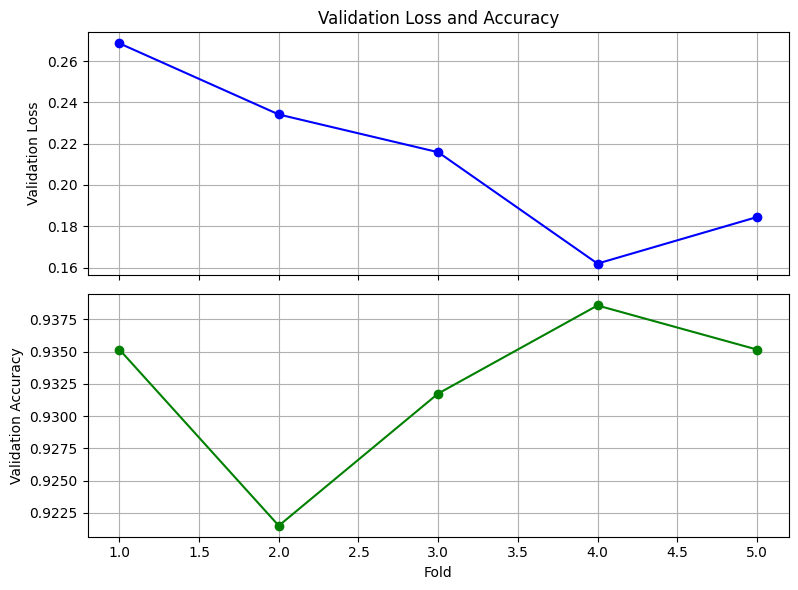

([0.2686212360858917,
  0.23416098952293396,
  0.21588250994682312,
  0.1619134098291397,
  0.18443159759044647],
 [0.935153603553772,
  0.9215016961097717,
  0.9317406415939331,
  0.9385665655136108,
  0.935153603553772])

In [45]:
# plotting 예시
# plot_validation_metrics(val_dict[1][0], val_dict[1][1])
plot_validation_metrics(val_dict[1][0], val_dict[1][1])
val_dict[1]

In [44]:
val_dict[13]

KeyError: 13

In [12]:
import csv

In [13]:
csv_file = "output_from_17.csv"

fieldnames = ["Index", "val_losses", "val_accuracies"]

with open(csv_file, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    
    # 헤더 작성
    writer.writeheader()
    
    # 데이터 작성
    for index, values in val_dict.items():
        val_losses = ", ".join([f"loss {loss}" for loss in values[0]])
        val_accuracies = ", ".join([f"acc {acc}" for acc in values[1]])
        row = {
            "Index": index,
            "val_losses": val_losses,
            "val_accuracies": val_accuracies
        }
        writer.writerow(row)
        


In [ ]:
for a in val_dict:
    print(val_dict[a][0])

[0.14187614619731903, 0.3102455139160156, 0.16044597327709198, 0.17473368346691132, 0.13264787197113037]
[1.8566075563430786, 0.07231798022985458, 0.5649966597557068, 0.9236502647399902, 0.3806503415107727]
[0.9585060477256775, 0.26275700330734253, 0.368999719619751, 0.27408382296562195, 0.36846688389778137]
[0.2533828318119049, 0.6882942318916321, 0.23714391887187958, 0.17823408544063568, 0.2279973030090332]
[2.9358259780565277e-05, 0.014573163352906704, 0.030070213600993156, 0.0008528577163815498, 0.02461107261478901]
[0.5553788542747498, 0.07665827870368958, 0.022700773552060127, 0.0006071897805668414, 0.00064460578141734]


In [ ]:
for file in file_list:
    _, y = npz_to_csv(file)
    if y[y[0] ==1].size / y.size > 0.1:
        proper_datasets.append(file)